In [1]:
import torch
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [2]:
data = pd.read_csv('../cleaned/twitter_cleaned_dataset.csv')  # Load your dataset here
data = data[data['Annotation'].isin(['racism', 'sexism'])]  # Filter for racism and sexism

In [5]:
#Map the labels to 0 and 1
data['label'] = data['Annotation'].map({'racism': 0, 'sexism': 1})  # Map labels to integers

#Step 2: Tokenize text using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
def tokenize_function(examples):
    return tokenizer(examples['cleaned_text'], padding='max_length', truncation=True)

data['cleaned_text'] = data['cleaned_text'].fillna('')

#Convert to Hugging Face Dataset
dataset = Dataset.from_pandas(data[['cleaned_text', 'label']])

dataset = dataset.map(tokenize_function, batched=True)

#Split the dataset into training and testing sets
train_dataset, test_dataset = dataset.train_test_split(test_size=0.2).values()

#Step 3: Load BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

#Step 4: Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    disable_tqdm=False,
)

#Step 5: Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=lambda p: {
        'accuracy': accuracy_score(p.label_ids, p.predictions.argmax(-1)),
        'report': classification_report(p.label_ids, p.predictions.argmax(-1), output_dict=True)
    }
)

#Step 6: Train the model
trainer.train()

#Step 7: Evaluate the model
results = trainer.evaluate(test_dataset)
print(results)


Map:   0%|          | 0/5347 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Jeevan\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Report
1,0.105500,0.112595,0.974766,"{'0': {'precision': 0.9612403100775194, 'recall': 0.96875, 'f1-score': 0.9649805447470817, 'support': 384.0}, '1': {'precision': 0.9824304538799414, 'recall': 0.978134110787172, 'f1-score': 0.9802775748721695, 'support': 686.0}, 'accuracy': 0.974766355140187, 'macro avg': {'precision': 0.9718353819787304, 'recall': 0.9734420553935861, 'f1-score': 0.9726290598096257, 'support': 1070.0}, 'weighted avg': {'precision': 0.9748257667583246, 'recall': 0.974766355140187, 'f1-score': 0.9747877995749418, 'support': 1070.0}}"
2,0.113900,0.096076,0.981308,"{'0': {'precision': 0.9972677595628415, 'recall': 0.9505208333333334, 'f1-score': 0.9733333333333334, 'support': 384.0}, '1': {'precision': 0.9730113636363636, 'recall': 0.9985422740524781, 'f1-score': 0.9856115107913669, 'support': 686.0}, 'accuracy': 0.9813084112149533, 'macro avg': {'precision': 0.9851395615996026, 'recall': 0.9745315536929058, 'f1-score': 0.9794724220623501, 'support': 1070.0}, 'weighted avg': {'precision': 0.981716462735212, 'recall': 0.9813084112149533, 'f1-score': 0.9812051368251193, 'support': 1070.0}}"
3,0.000200,0.131539,0.976636,"{'0': {'precision': 0.9686684073107049, 'recall': 0.9661458333333334, 'f1-score': 0.9674054758800521, 'support': 384.0}, '1': {'precision': 0.9810771470160117, 'recall': 0.9825072886297376, 'f1-score': 0.9817916970138383, 'support': 686.0}, 'accuracy': 0.9766355140186916, 'macro avg': {'precision': 0.9748727771633583, 'recall': 0.9743265609815355, 'f1-score': 0.9745985864469452, 'support': 1070.0}, 'weighted avg': {'precision': 0.976623917065696, 'recall': 0.9766355140186916, 'f1-score': 0.9766287914854515, 'support': 1070.0}}"


{'eval_loss': 0.13153871893882751, 'eval_accuracy': 0.9766355140186916, 'eval_report': {'0': {'precision': 0.9686684073107049, 'recall': 0.9661458333333334, 'f1-score': 0.9674054758800521, 'support': 384.0}, '1': {'precision': 0.9810771470160117, 'recall': 0.9825072886297376, 'f1-score': 0.9817916970138383, 'support': 686.0}, 'accuracy': 0.9766355140186916, 'macro avg': {'precision': 0.9748727771633583, 'recall': 0.9743265609815355, 'f1-score': 0.9745985864469452, 'support': 1070.0}, 'weighted avg': {'precision': 0.976623917065696, 'recall': 0.9766355140186916, 'f1-score': 0.9766287914854515, 'support': 1070.0}}, 'eval_runtime': 565.145, 'eval_samples_per_second': 1.893, 'eval_steps_per_second': 0.119, 'epoch': 3.0}


In [6]:
model.save_pretrained('./model')
tokenizer.save_pretrained('./saved_model')

('./saved_model\\tokenizer_config.json',
 './saved_model\\special_tokens_map.json',
 './saved_model\\vocab.txt',
 './saved_model\\added_tokens.json')

In [8]:
# Get predictions
predictions = trainer.predict(test_dataset)
pred_labels = torch.argmax(torch.tensor(predictions.predictions), axis=1).cpu().numpy()

# Extract the test texts and labels
if hasattr(test_dataset, 'indices'):
    test_texts = data.iloc[test_dataset.indices]['cleaned_text'].tolist()
    test_labels = data.iloc[test_dataset.indices]['label'].tolist()
else:
    test_texts = test_dataset['cleaned_text']
    test_labels = test_dataset['label']

# Create the results DataFrame
df_results = pd.DataFrame({
    'cleaned_text': test_texts,
    'true_label': test_labels,
    'predicted_label': pred_labels
})

# Save to CSV
df_results.to_csv('bert_predictions.csv', index=False)

# Display sample results
print(df_results.head())

                                        cleaned_text  true_label  \
0  rt  i would happily pay more for a flight if i...           1   
1                       up your ass terrorist bitch.           0   
2  what a riveting little lesson in walking the c...           1   
3  rape is not a synonym for "depleted."  just ra...           1   
4  since the islamist erdogan came to power,women...           0   

   predicted_label  
0                1  
1                1  
2                1  
3                1  
4                0  


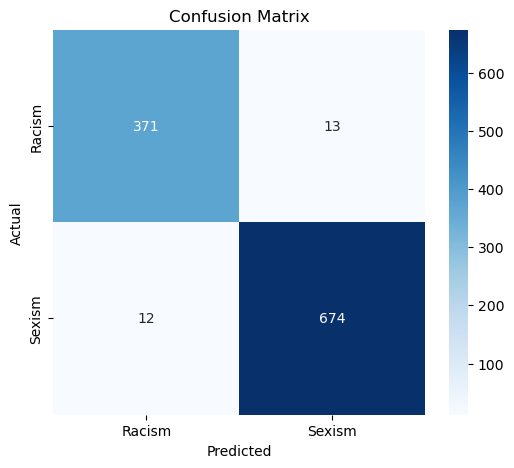

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(df_results['true_label'], df_results['predicted_label'])

# Plot heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Racism', 'Sexism'], yticklabels=['Racism', 'Sexism'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

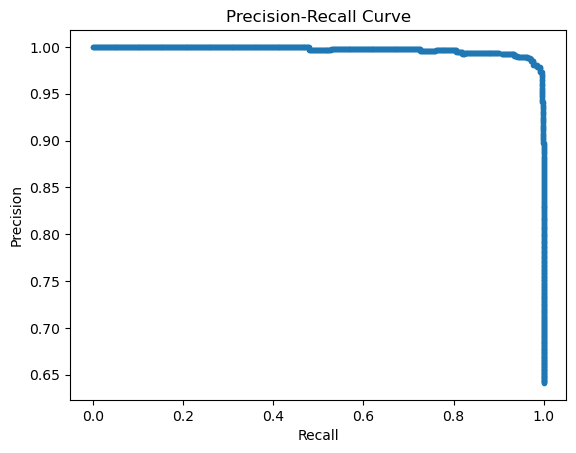

In [10]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(df_results['true_label'], predictions.predictions[:, 1])

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


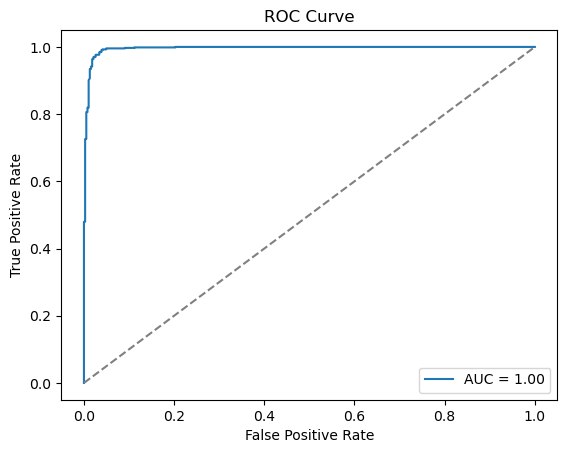

In [11]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(df_results['true_label'], predictions.predictions[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

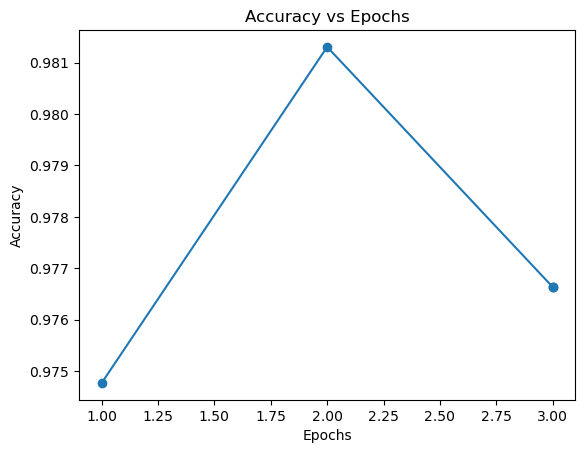

In [12]:
log_history = trainer.state.log_history  # Extract logs
epochs = [log['epoch'] for log in log_history if 'eval_loss' in log]
accuracy = [log['eval_accuracy'] for log in log_history if 'eval_loss' in log]

plt.plot(epochs, accuracy, marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs")
plt.show()


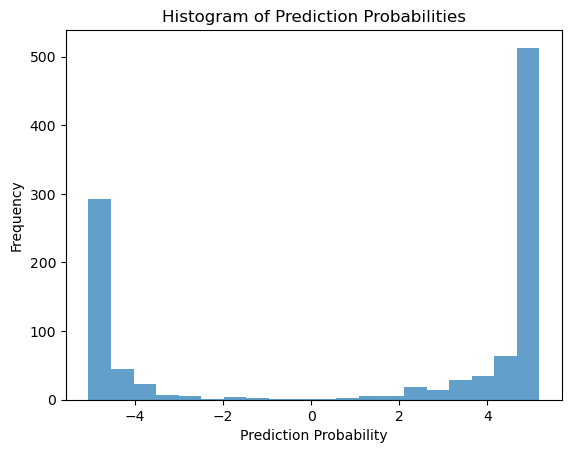

In [24]:
import numpy as np

probs = predictions.predictions[:, 1]  # Probability for "sexism"
plt.hist(probs, bins=20, alpha=0.7)
plt.xlabel("Prediction Probability")
plt.ylabel("Frequency")
plt.title("Histogram of Prediction Probabilities")
plt.show()


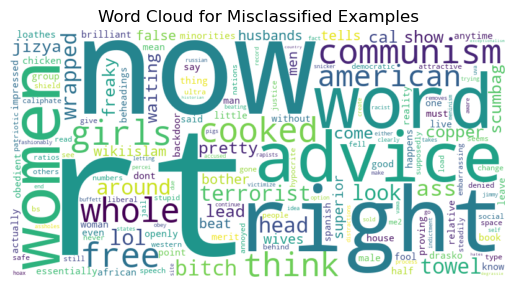

In [41]:
from wordcloud import WordCloud
misclassified_text = df_results[df_results['true_label'] != df_results['predicted_label']]['cleaned_text']
text = ' '.join(misclassified_text)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Misclassified Examples")
plt.show()


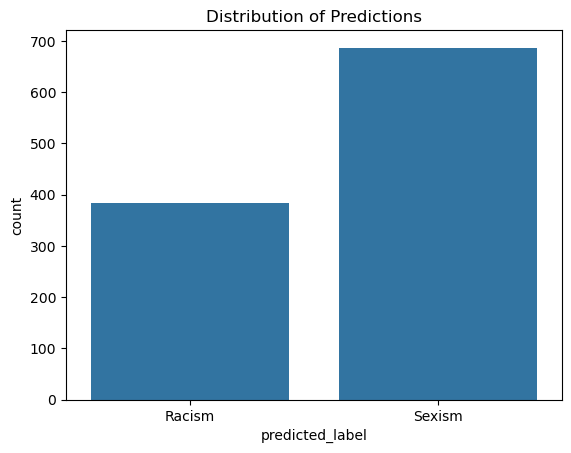

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=df_results['predicted_label'])
plt.xticks(ticks=[0, 1], labels=['Racism', 'Sexism'])
plt.title("Distribution of Predictions")
plt.show()


In [51]:
import pandas as pd

# Check the counts of racism (0) vs. sexism (1)
print(df_results['true_label'].value_counts())


true_label
1    686
0    384
Name: count, dtype: int64


In [52]:
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Convert text to numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Use top 5000 words
X_tfidf = vectorizer.fit_transform(data['cleaned_text'])

# Apply SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, data['label'])

# Convert back to a DataFrame
df_balanced = pd.DataFrame(X_resampled.toarray(), columns=vectorizer.get_feature_names_out())
df_balanced['label'] = y_resampled

print(df_balanced['label'].value_counts())  # Now both classes should be balanced

label
0    3377
1    3377
Name: count, dtype: int64


In [53]:
from imblearn.under_sampling import RandomUnderSampler

# Define the undersampler
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Apply undersampling
X_resampled, y_resampled = undersampler.fit_resample(X_tfidf, data['label'])

# Convert back to DataFrame
df_balanced = pd.DataFrame(X_resampled.toarray(), columns=vectorizer.get_feature_names_out())
df_balanced['label'] = y_resampled

print(df_balanced['label'].value_counts())  # Now both classes should be balanced

label
0    1970
1    1970
Name: count, dtype: int64


In [56]:
from sklearn.utils import resample

# Separate majority and minority class
df_majority = data[data.label == 0]  # Racism
df_minority = data[data.label == 1]  # Sexism

# Oversample the minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,  # Sample with replacement
                                 n_samples=len(df_majority),  # Match majority class
                                 random_state=42)

# Combine both classes
df_balanced = pd.concat([df_majority, df_minority_upsampled])

# Now re-tokenize the text and train the model as before
